In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import os
os.chdir('C://work/dev/python/progs/texts/sec_bert/')

# Объявления

In [70]:
import pandas as pd
import numpy as np
import phik
from itertools import chain


import joblib
from sklearn.metrics import average_precision_score

In [71]:
from ruamel.yaml import YAML
conf = YAML().load(open('params.yaml'))
np.random.seed(conf['seed'])

# Загружаем

In [72]:
import pandas as pd
import numpy as np
import joblib
import json
import click
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [73]:
feat_data = pd.read_csv(conf['feat_eng']['feat_final_fn'])

mlb = joblib.load(conf['prep_text']['mlb_fn'])
data = pd.read_csv(conf['feat_gen']['data_fn'])

data['target'] = data['target'].map(lambda x: eval(x))

data['labels'] = data['labels'].map(lambda x: eval(x))


tr_idx = data.query('split=="tr"').index
val_idx = data.query('split=="val"').index
ts_idx = data.query('split=="ts"').index


In [74]:
col_l = feat_data.columns

In [75]:
data['sentence'].str.split().str.len().describe(percentiles=[0.9, 0.95, 0.97])

count    14358.000000
mean        26.226285
std         38.423265
min          2.000000
50%         17.000000
90%         34.000000
95%         55.000000
97%        132.000000
max        640.000000
Name: sentence, dtype: float64

# Байес

In [76]:
from sklearn.naive_bayes import MultinomialNB

# пока лучшая версия
model = OneVsRestClassifier(MultinomialNB(alpha=0.0001, fit_prior=False))

# # хуже версия
# model = OneVsRestClassifier(LogisticRegression(random_state=conf['seed'], 
#                                                class_weight=conf['train_eval_model']['balanced'], max_iter=10000))

## самая слабая версия
# model = LogisticRegression(random_state=conf['seed'], 
#                                                class_weight=conf['train_eval_model']['balanced'], max_iter=10000)
# if conf['train_eval_model']['chain']:
#     wrap_class = ClassifierChain
# else:
#     wrap_class = OneVsRestClassifier
# model = make_pipeline(RobustScaler(), wrap_class(model, random_state=conf['seed'])) if conf['train_eval_model']['chain'] else make_pipeline(RobustScaler(), wrap_class(model))

                            
model.fit(feat_data.loc[tr_idx].astype(np.float16).values, np.array(data.loc[tr_idx, 'target'].values.tolist()))


OneVsRestClassifier(estimator=MultinomialNB(alpha=0.0001, fit_prior=False))

## оценим качество

In [77]:
from src.train_eval_model import metric_multi
Y_val = np.array(data.loc[val_idx, 'target'].values.tolist())
X_val = feat_data.loc[val_idx].astype(np.float16).values

Y_val_proba = model.predict_proba(X_val)

roc_auc, _ = metric_multi(Y_val, Y_val_proba, roc_auc_score)
logloss, _ = metric_multi(Y_val, Y_val_proba, log_loss, labels=[0,1])
pr_auc, _ = metric_multi(Y_val, Y_val_proba, average_precision_score)

logloss, roc_auc, pr_auc


(0.4112147747655164, 0.9356705027145835, 0.674386972502036)

In [78]:
# перекос на класс defence_evasion
(Y_val_proba>0.6)[:,0].mean()

0.10625

## построим вероятности для слов

In [79]:
# формируем массив слов примечательных для атак
feat_cols_ar = np.eye(len(col_l))

feat_cols_probs = model.predict_proba(feat_cols_ar)
col_prob_df = pd.DataFrame(feat_cols_probs, index=col_l, columns=mlb.classes_)

cls_d = {}
for num, cls in enumerate(mlb.classes_):
    idx = np.argsort(feat_cols_probs[:, num])
    cls_d[cls] = [(col_l[it], feat_cols_probs[:, num][it]) for it in idx]
    

## где ошибается

In [223]:
res_df = pd.DataFrame()
res_df['y'] = Y_val.tolist()
res_df['y_proba'] = Y_val_proba.tolist()

### разные границы для всех

In [237]:
Y_tr = np.array(data.loc[tr_idx, 'target'].values.tolist())
Y_tr_proba = model.predict_proba(feat_data.loc[tr_idx].astype(np.float16).values)


In [238]:
y_true = Y_tr
probas = Y_tr_proba
logreg_thresh_l = []
res_d = {}

In [239]:
p, r, f1, _ = precision_recall_fscore_support(y_true, (probas>0.5).astype(int), average='micro')
f1

0.5663756943657182

In [240]:
num_cls = len(mlb.classes_)

for i in range(num_cls):
    res_metrics_l = []
    for thresh in np.arange(0.05, 0.95, 0.05):
        
        y_i = y_true[:,i]
        proba_i = (probas[:,i]>thresh).astype(int)
        p, r, f1, sup = [it[1] for it in precision_recall_fscore_support(y_i, proba_i)]

        res_metrics_df = pd.DataFrame({'precision':p, 'recall':r, 'f1':f1, 'sup':sup}, index=[thresh])
        res_metrics_l.append(res_metrics_df)


    res_d[i] = pd.concat([it for it in res_metrics_l], axis=0)
    logreg_thresh_l.append(res_d[i].index[res_d[i]['f1'].argmax()].round(3))

preds = np.apply_along_axis(lambda x: x>=x[-1], 0, np.vstack([probas, logreg_thresh_l]))[:-1].astype(int)

In [241]:
p, r, f1, _ = precision_recall_fscore_support(y_true, (preds).astype(int), average='micro')
f1

0.7015851715172355

In [242]:
thresh_col = 'y_p'
res_df[thresh_col] = res_df['y_proba'].map(lambda x: [int(val>=thresh) for val, thresh in zip(x, logreg_thresh_l)])

In [243]:
error_df = data.loc[val_idx].reset_index(names='val_idx').join(res_df[['y', 'y_proba', thresh_col]])
error_df['prob_label'] = mlb.inverse_transform(np.array(error_df[thresh_col].tolist()))

In [245]:
p, r, f1, sup = precision_recall_fscore_support(np.array(res_df['y'].values.tolist()), 
                                                    np.array(res_df[thresh_col].values.tolist()), average='micro')
f1

0.6993077832179638

### какие классы хуже предсказываются

In [247]:
fin_metric, res_l = metric_multi(np.array(error_df['y'].tolist()), np.array(error_df[thresh_col].tolist()), average_precision_score)

pd.DataFrame({'qual':res_l, 'class':mlb.classes_}).sort_values(by='qual').head(15)

,qual,class
10,0.136267,reconnaissance
6,0.306148,lateral-movement
13,0.330382,exfiltration
11,0.346120,impact
12,0.389165,initial-access
9,0.407678,resource-development
7,0.439639,credential-access
3,0.493920,persistence
0,0.508295,defense-evasion
5,0.550833,collection


In [235]:
# idx = 2396
# row = error_df[['labels', 'prob_label']].loc[idx]

df_l = []
for idx in range(error_df[['labels', 'prob_label']].shape[0]):
    row = error_df[['labels', 'prob_label']].iloc[idx]

    

# idx = 2396
# row = error_df[['labels', 'prob_label']].iloc[idx]

    row_l = []
    good_s = set(row['labels']).intersection(row['prob_label'])
    if len(good_s)>0:
        for it in good_s:
            row_l.append(pd.DataFrame({'labels':it, 'prob_label':it}, index=[idx]))
            
    in_labels_s = set(row['labels']).difference(row['prob_label'])
    in_probas_s = set(row['prob_label']).difference(row['labels'])
    l1 = len(in_labels_s)
    l2 = len(in_probas_s)

    if l1>0 or l2>0:
        row_l.append(pd.DataFrame({'labels':[in_labels_s], 'prob_label':[in_probas_s]}, index=[idx]))
    # if len(in_labels_s)>0:
    #     for it in in_labels_s:
    #         row_l.append(pd.DataFrame({'labels':it, 'prob_label':'empty'}, index=[idx]))
            
    
    # if len(in_probas_s)>0:
    #     for it in in_probas_s:
    #         row_l.append(pd.DataFrame({'labels':'empty', 'prob_label':it}, index=[idx]))
    df_l.append(pd.concat(row_l))

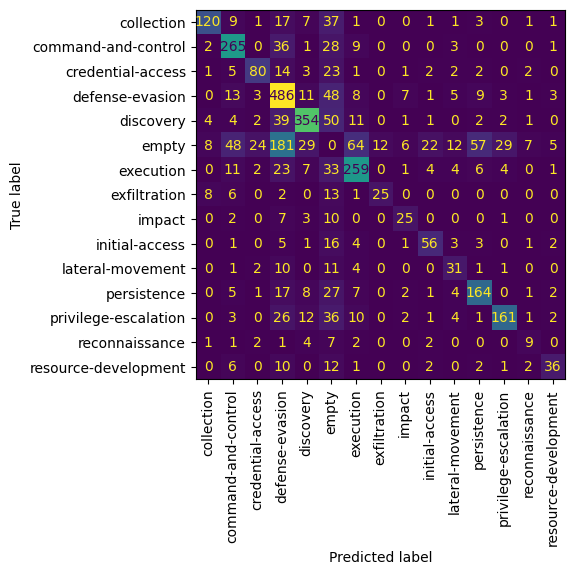

In [236]:
from sklearn.metrics import ConfusionMatrixDisplay
conf_df = pd.concat(df_l).explode(['prob_label']).explode(['labels']).fillna('empty')
ConfusionMatrixDisplay.from_predictions(y_true = conf_df['labels'], y_pred = conf_df['prob_label'], colorbar=False,
                                        xticks_rotation='vertical')

In [163]:
conf_df = conf_df.reset_index()

In [180]:
conf_df

,index,labels,prob_label
0,0,execution,execution
1,1,resource-development,resource-development
2,2,resource-development,resource-development
3,2,empty,command-and-control
4,3,command-and-control,command-and-control
...,...,...,...
3804,2396,initial-access,discovery
3805,2396,persistence,discovery
3806,2397,impact,impact
3807,2398,impact,empty


#### defense-evasion

In [154]:
cls = 'defense-evasion'


In [165]:
cls_idx = conf_df['labels']==cls

In [168]:
conf_df.loc[cls_idx, 'prob_label'].value_counts()

prob_label
defense-evasion         329
empty                   125
execution                26
discovery                22
persistence              21
privilege-escalation     21
impact                   20
command-and-control      19
lateral-movement         12
collection               11
resource-development     10
initial-access            9
exfiltration              8
credential-access         6
reconnaissance            4
Name: count, dtype: int64

In [182]:
conf_cls = 'empty'
conf_idx = conf_df.loc[cls_idx & (conf_df.prob_label==conf_cls), 'index'].unique().tolist()

##### смотрим на кейс

In [191]:
N=0

with pd.option_context('display.max_colwidth', 1000):
    display(error_df.iloc[conf_idx].iloc[N])

val_idx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   18
sentence         An adversary may revert changes made to a cloud instance after they have performed malicious activities in attempt to evade detection and remove evidence of their presence. In highly virtualized environments, such as c

In [194]:
mlb.classes_

array(['defense-evasion', 'privilege-escalation', 'execution',
       'persistence', 'command-and-control', 'collection',
       'lateral-movement', 'credential-access', 'discovery',
       'resource-development', 'reconnaissance', 'impact',
       'initial-access', 'exfiltration'], dtype=object)

##### смотрим на фичи

In [190]:
feat_data.iloc[18].loc[lambda x: x>0]

data           0.058026
persist        0.093602
api            0.070928
malici         0.055108
such           0.061342
citat googl    0.099505
googl          0.086549
Name: 18, dtype: float64

##### значимость в облаке слов

In [196]:
col_prob_df.loc['persist']

defense-evasion         0.437543
privilege-escalation    0.876619
execution               0.225680
persistence             0.982138
command-and-control     0.191315
collection              0.231217
lateral-movement        0.087717
credential-access       0.376708
discovery               0.000047
resource-development    0.000334
reconnaissance          0.000596
impact                  0.372788
initial-access          0.751409
exfiltration            0.000337
Name: persist, dtype: float64

#### impact

In [105]:
cls = 'impact'

In [106]:
cls_idx = error_df['labels'].map(lambda x: cls in x)

In [107]:
y = np.array(error_df.loc[cls_idx, 'target'].values.tolist())
y_p = np.array(error_df.loc[cls_idx, thresh_col].values.tolist())

In [108]:
p, r, f1, sup = precision_recall_fscore_support(y, y_p, average='micro')

p, r, f1, sup

(0.5573770491803278, 0.7727272727272727, 0.6476190476190476, None)

In [109]:
error_df.loc[cls_idx, ['prob_label']].explode('prob_label').value_counts(dropna=False)

prob_label          
impact                  34
defense-evasion         13
NaN                      7
collection               3
discovery                3
command-and-control      2
execution                1
exfiltration             1
initial-access           1
privilege-escalation     1
reconnaissance           1
resource-development     1
Name: count, dtype: int64

<div class='alert alert-info'>
    
- impact путается с defense-evasion
- немного с collection и discovery
</div>

In [31]:
N=0

with pd.option_context('display.max_colwidth', 500):
    display(error_df.loc[cls_idx].iloc[N])

val_idx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           40
sentence         Adversaries may launch a denial of service (DoS) attack targeting an endpoint's operating system (OS). A system's OS is responsible for managing the finite resources as well as preventing the entire system from being overwhelmed by excessive demands on its capacity. These attacks do not need to exhaust the actual resources on a system; the attacks may simply exhaust the limits and available resources that an OS self-imposes.\n\nDifferent ways to achieve this exi

In [32]:
feat_data.loc[val_idx].reset_index()[cls_idx].iloc[N].loc[lambda x: x>0]

index            40.000000
target            0.110326
server            0.071572
oper              0.036434
system            0.147388
access            0.037554
servic            0.107975
sent              0.097244
for               0.149623
it                0.071603
such              0.037220
been              0.041900
connect           0.047017
connect.1         0.047017
connect.2         0.047017
from              0.028974
denial servic     0.071708
Name: 7, dtype: float64

In [33]:
col_prob_df.loc['DoS']

KeyError: 'DoS'

In [34]:
y_p[:,0].mean()

0.29545454545454547

In [35]:
np.array(data.loc[tr_idx]['target'].tolist())[:, 0].mean()

0.24657963446475195

## главные слова тактик

In [224]:
cls_d['defense-evasion'][-10:]

[('dll', 0.7996392018454358),
 ('disabl', 0.8164761247024322),
 ('sign', 0.8248165793683071),
 ('obfusc', 0.830973359326624),
 ('bypass', 0.8446198625882976),
 ('pass the', 0.848739920600278),
 ('hidden', 0.8642184034116897),
 ('decrypt', 0.8871889437108471),
 ('uac', 0.9490013365751169),
 ('use dll', 0.9999858144238292)]

In [225]:
cls_d['impact'][-10:]

[('destroy 2018', 0.39883677085220354),
 ('stop', 0.4081634586405214),
 ('mine', 0.4687043360003906),
 ('goal', 0.5038434083678075),
 ('destroy', 0.535323708631271),
 ('overwrit', 0.5474879382127805),
 ('shadow', 0.5858543825428222),
 ('ransom', 0.7304021301267504),
 ('denial servic', 0.8201458819981089),
 ('mbr', 0.8505373067624795)]

<div class='alert alert-info'>

- в некоторых тактиках могут появиться слова, которых нет (например, tcp в exfiltration при сглаживании - alpha = 1) 
- Если задать fit_prior=False, то мы сбалансируем выборки перед обучением, так как иначе будут априорная вероятность будет подбираться, учитывая неравномерность в количестве встречаемости
</div>

### проверка

In [ ]:
word = 'gather'

#### слово по тактикам


In [39]:
idx_word = np.where(feat_cols==word)[0][0]


In [40]:
themes = np.argsort(feat_cols_probs[idx_word]) 
probs = np.sort(feat_cols_probs[idx_word])
themes, probs

(array([11, 12,  6,  4,  1,  3,  9,  0, 13,  2, 10,  5,  7,  8],
       dtype=int64),
 array([0.00224125, 0.0022719 , 0.00275761, 0.00320066, 0.00494394,
        0.00569306, 0.00769047, 0.01945607, 0.02389086, 0.04741253,
        0.06084578, 0.07219202, 0.08770189, 0.43687638]))

In [41]:
N=5
mlb.classes_[themes[-N:][::-1]]


array(['discovery', 'credential-access', 'collection', 'reconnaissance',
       'execution'], dtype=object)

При fit_prior=False слова сильнее повышают вероятность малых классов 'impact', 'exfiltration'

#### слово для тактики


In [44]:
data.explode('labels').query('labels=="exfiltration" and sentence.str.contains(@word)')

,sentence,labels,prep_text,target,split,threat_words
308,"Adversaries may exfiltrate data, such as sensi...",exfiltration,may exfiltr data such sensit document through...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
7472,[Doki] has used a script that gathers informat...,exfiltration,doki has use script that gather from hardcod ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
7477,[Ebury] can automatically exfiltrate gathered ...,exfiltration,eburi can exfiltr gather ssh citat eset windi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
7483,[Gamaredon Group] has used modules that automa...,exfiltration,gamaredon group has use modul that upload gat...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
8767,[Empire] can send data gathered from a target ...,exfiltration,empir can send data gather from target throug...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
8775,[Ursnif] has used HTTP POSTs to exfil gathered...,exfiltration,ursnif has use http post exfil gather citat t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
8778,[CharmPower] can exfiltrate gathered data to a...,exfiltration,charmpow can exfiltr gather data hardcod url ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
8802,"[FunnyDream] can execute commands, including g...",exfiltration,funnydream can execut command includ gather u...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
8845,[Kessel] has exfiltrated information gathered ...,exfiltration,kessel has gather from the infect system the ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]
8851,[Rising Sun] can send data gathered from the i...,exfiltration,rise sun can send data gather from the infect...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",tr,[]


#### распределение тактик с конкретным словом


In [45]:
data.explode('labels').assign(has_sent = lambda x: x['sentence'].str.contains(word)).pivot_table(index='labels', values='has_sent', aggfunc=['count', 'sum', 'mean'
]).sort_values(by=('mean', 'has_sent'), ascending=False)

,count,sum,mean
,has_sent,has_sent,has_sent
labels,,,
reconnaissance,152,50,0.328947
discovery,3211,260,0.080972
credential-access,1050,61,0.058095
exfiltration,401,17,0.042394
collection,1357,42,0.030951
resource-development,398,7,0.017588
impact,264,4,0.015152
execution,2731,32,0.011717


## какие это тактики

In [55]:
word_values_attack = {k:np.sum([it[1] for it in v]) for k,v in cls_d.items()}
thresh = pd.Series(word_values_attack).quantile(0.3)

In [56]:
{k:v for k,v in cls_d.items() if np.sum([ it[1] for it in v])<thresh}

{'resource-development': [('creat', 0.026041472889922694),
  ('server', 0.02664449696286266),
  ('citat', 0.027422153453069843),
  ('for', 0.03295371761796157),
  ('has', 0.037530519872121096),
  ('email', 0.03874940279772653),
  ('account', 0.042682979543648136),
  ('legitim', 0.04906706426545268),
  ('obtain', 0.12715787931153832),
  ('mimikatz', 0.1332939814427944)],
 'reconnaissance': [('identifi', 0.012079882841152306),
  ('obtain', 0.013384441953763785),
  ('access', 0.013603451507283591),
  ('victim', 0.0140446038951574),
  ('email', 0.014743845140746767),
  ('collect', 0.01552624685956348),
  ('address', 0.0199154001412228),
  ('about', 0.05589173657117092),
  ('gather', 0.06084578061384603),
  ('search', 0.08067751840493648)],
 'impact': [('can', 0.01259819404464767),
  ('victim', 0.013069661521971426),
  ('/code', 0.01670622437791487),
  ('citat', 0.017016729078916323),
  ('data', 0.017477476366829937),
  ('system', 0.021901594853876456),
  ('servic', 0.021996330993009412),
 

## logloss в зависимости от балансировки

In [13]:
from sklearn.naive_bayes import MultinomialNB
from src.train_eval_model import metric_multi


model1 = OneVsRestClassifier(MultinomialNB(alpha=0.0001, fit_prior=False))
model2 = OneVsRestClassifier(MultinomialNB(alpha=0.0001, fit_prior=True))

model1.fit(feat_data.loc[tr_idx].astype(np.float16).values, np.array(data.loc[tr_idx, 'target'].values.tolist()))
model2.fit(feat_data.loc[tr_idx].astype(np.float16).values, np.array(data.loc[tr_idx, 'target'].values.tolist()))


Y_val = np.array(data.loc[val_idx, 'target'].values.tolist())
X_val = feat_data.loc[val_idx].astype(np.float16).values

Y_val_proba1 = model1.predict_proba(X_val)
Y_val_proba2 = model2.predict_proba(X_val)

logloss1, vals1 = metric_multi(Y_val, Y_val_proba1, log_loss, labels=[0,1])
logloss2, vals2 = metric_multi(Y_val, Y_val_proba2, log_loss, labels=[0,1])

logloss1, logloss2

(0.4112147747655164, 0.19301847368082892)

In [14]:
i = 13
log_loss(Y_val[:, i], Y_val_proba1[:, i]), log_loss(Y_val[:, i], Y_val_proba2[:, i])

(0.3741743720808009, 0.07896847922260394)

In [ ]:
# тут основная функция на самом деле
# чтобы избежать декораторов поставим точки останова прямо в функции
from sklearn.metrics._classification import log_loss as log_loss_
# line 2922

# log_loss_(Y_val[:, i], Y_val_proba1[:, i])

In [54]:
from scipy.special import xlogy
from sklearn.utils._array_api import _average

y_pred = Y_val_proba1[:, i].reshape(-1,1)
transformed_labels = Y_val[:, i].reshape(-1,1)

eps = np.finfo(y_pred.dtype).eps

transformed_labels = np.append(
            1 - transformed_labels, transformed_labels, axis=1
        )
y_pred = np.append(1 - y_pred, y_pred, axis=1)

# кстати это аналогично сглаживанию в fastai?
y_pred = np.clip(y_pred, eps, 1 - eps)

loss = -xlogy(transformed_labels, y_pred).sum(axis=1)
# float(_average(loss, weights=None, normalize=True))
loss.mean()

0.3741743720808009

In [66]:
# там, где 1 по идее нет такого всплеска 
# там, где класс = 0 всплеск значений вероятности

idx0 = np.where(Y_val[:, i]==0)[0].tolist()
idx1 = np.where(Y_val[:, i]==1)[0].tolist()

# при одинаковом распределении в logloss при 1 лучший вклад вносится, 
# зато из-за средних вероятностей и вклад для 0 больше, что влияет на потери сильно, так как 0 больше значительно
(Y_val_proba1[idx1, i].mean(), Y_val_proba2[idx1, i].mean(), 
Y_val_proba1[idx0, i].mean(), Y_val_proba2[idx0, i].mean())


(0.6660543594967968,
 0.061302801225221734,
 0.28567279502412374,
 0.011495714607628616)

# Остальное

### одна граница для всех

In [81]:
for thresh in np.arange(0.1, 0.9, 0.05):
    res_df[f'y_p_{str(thresh.round(2))}'] = res_df['y_proba'].map(lambda x: [int(it>thresh) for it in x])

In [82]:
y_p_cols = [it for it in res_df.columns if 'y_p_' in it]


In [83]:
from sklearn.metrics import precision_recall_fscore_support
pres_l = []
f1_l = []
rec_l = []
sup_l = []

for col in y_p_cols:
    p, r, f1, sup = precision_recall_fscore_support(np.array(res_df['y'].values.tolist()), 
                                                    np.array(res_df[col].values.tolist()), average='micro')
    pres_l.append(p)
    rec_l.append(r)
    f1_l.append(f1)
    sup_l.append(sup)

thresh_df = pd.DataFrame({'pres':pres_l, 'recall':rec_l, 'f1':f1_l, 'sup':sup_l}, index=y_p_cols)

In [84]:
thresh_col = thresh_df.index[thresh_df['f1'].argmax()]

error_df = data.loc[val_idx].reset_index(names='val_idx').join(res_df[['y', 'y_proba', thresh_col]])
error_df['prob_label'] = mlb.inverse_transform(np.array(error_df[thresh_col].tolist()))


In [85]:
error_df.sample(1)

,val_idx,sentence,labels,url,par_name,origin_labels,prep_text,target,split,threat_words,y,y_proba,y_p_0.55,prob_label
1950,11526,"During [Operation CuckooBees], the threat acto...",[execution],https://attack.mitre.org/techniques/T1059/003,Command and Scripting Interpreter,['T1059.003'],dure oper cuckoobe the threat actor use batch...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",val,[],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.5024607179457661, 0.47205612310684986, 0.56...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","(execution,)"


## с метками по одной

In [7]:
exp_df = feat_data.assign(labels= data['labels']).explode('labels')

In [8]:
col_l = [col for col in exp_df.columns if not 'truncated' in col]
exp_df = exp_df[col_l]

In [ ]:
from sklearn.linear_model import LogisticRegression
feat_sel_model = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1,
                                    random_state=conf['seed'], max_iter=10000)
feat_sel_model.fit(exp_df.drop(columns='labels').astype(np.float16), exp_df['labels'].fillna('no'))

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [15]:
coef_ar = feat_sel_model.coef_
(coef_ar==0).sum()

237417

In [16]:
(coef_ar==0).mean()

0.9785347758887172

In [ ]:
Какая форма вывода коэффициентов логистической регрессии (.coef_) для мультиклассовой классификации

In [12]:
exp_df.columns.shape

(16176,)

### phik

In [30]:
lower = exp_df.stack().quantile(0.05)

MemoryError: Unable to allocate 4.66 GiB for an array with shape (625697525,) and data type float64

In [17]:
res_ser = exp_df.mean(axis=0)


KeyboardInterrupt



In [ ]:
res_ser.mean()